# RNA-seq comparison vs H3K4me3 and H3K36me3

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 33


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 33


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 33


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 33


,file,modification,cell,replicate,peaks,tool,dataset
5,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,K562,rep2,32386,MACS2,ENCODE
19,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,HepG2,rep2,3561,MACS2,ENCODE
112,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K36me3,HMEC,rep1,15662,SPAN,ENCODE
11,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,HSMM,rep2,12203,MACS2,ENCODE
42,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,Huvec,rep2,11257,MACS2 broad,ENCODE


In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 20


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 20


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 20


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 20


,file,modification,cell,replicate,peaks,tool,dataset
15,/home/jetbrains/data/2023_Immune/macs2/PBMC_H3...,H3K36me3,PBMC,,110695,MACS2,Roadmap
64,/home/jetbrains/data/2023_Immune/span/CD34_H3K...,H3K36me3,CD34,rep1,25138,SPAN,Roadmap
42,/home/jetbrains/data/2023_Immune/sicer/CD4_H3K...,H3K36me3,CD4,rep1,27467,SICER,Roadmap
38,/home/jetbrains/data/2023_Immune/macs2/CD4ABT_...,H3K4me3,CD4ABT,rep2,33576,MACS2 broad,Roadmap
18,/home/jetbrains/data/2023_Immune/macs2/CD4_H3K...,H3K4me3,CD4,,28519,MACS2,Roadmap


In [9]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

In [10]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

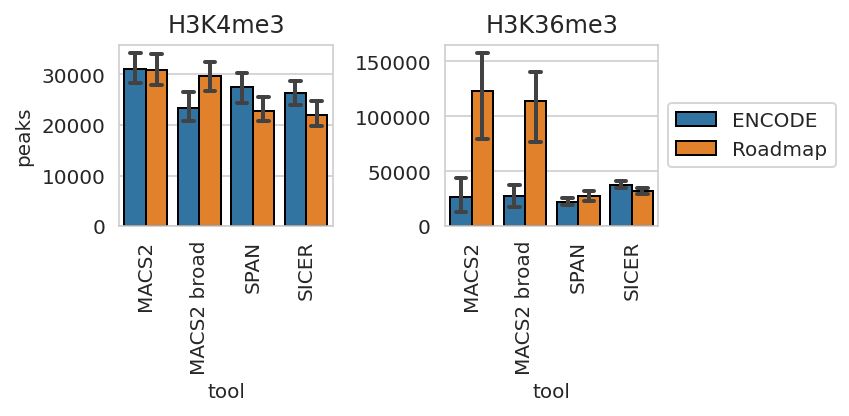

In [11]:
plt.figure(figsize=(6, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# H3K4me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps the promoter of an expressed gene (RPKM > 0.5).
The top 15 000 peak calls from the different methods are ranked by their significance or by their fold enrichment for the thresholding method. We plotted the correct peak fraction (fraction of the top 1000xn peaks that overlap with active promoters) detected as a function of the correct promoter fraction (fraction of the active promoters that overlap with the top 1000xn peaks).

In [12]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

,chromosome,db,type,start,end,point1,strand,point2,aux
2966803,chr19,HAVANA,exon,34431861,34431931,.,+,.,"gene_id ""ENSG00000126261.13""; transcript_id ""E..."
3016817,chr19,HAVANA,CDS,47130931,47131080,.,+,0,"gene_id ""ENSG00000142230.13""; transcript_id ""E..."
210606,chr1,HAVANA,UTR,156312041,156312221,.,-,.,"gene_id ""ENSG00000163468.15""; transcript_id ""E..."
974644,chr5,HAVANA,exon,73504347,73504403,.,+,.,"gene_id ""ENSG00000145741.17""; transcript_id ""E..."
2771693,chr17,HAVANA,CDS,67722580,67722637,.,+,1,"gene_id ""ENSG00000130935.10""; transcript_id ""E..."
1673638,chr10,HAVANA,exon,27231748,27231820,.,-,.,"gene_id ""ENSG00000107897.20""; transcript_id ""E..."
1830954,chr11,HAVANA,CDS,22221097,22221210,.,+,0,"gene_id ""ENSG00000171714.13""; transcript_id ""E..."
768962,chr3,HAVANA,exon,184352416,184352810,.,-,.,"gene_id ""ENSG00000114859.16""; transcript_id ""E..."
2817971,chr18,HAVANA,UTR,712588,712615,.,-,.,"gene_id ""ENSG00000132199.20""; transcript_id ""E..."
2243465,chr14,HAVANA,start_codon,24115595,24115597,.,+,0,"gene_id ""ENSG00000100897.18""; transcript_id ""E..."


In [13]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [14]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


,chromosome,db,type,start,end,point1,strand,point2,gene_id,gene_type,gene_name,level
1574836,chr9,HAVANA,gene,87966441,87974753,.,-,.,ENSG00000156345,protein_coding,CDK20,1
1677739,chr10,HAVANA,gene,31628540,31628599,.,-,.,ENSG00000231855,unprocessed_pseudogene,ENSG00000231855,2
1169150,chr6,HAVANA,gene,84124241,84227643,.,-,.,ENSG00000135315,protein_coding,CEP162,2
3319562,chrX,HAVANA,gene,96337236,96337912,.,-,.,ENSG00000271209,processed_pseudogene,BRDTP1,1
440950,chr2,HAVANA,gene,126656133,126696667,.,+,.,ENSG00000136732,protein_coding,GYPC,1


## Annotate quanitified RNA-seq with TSS positions

In [15]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

In [16]:
import re

GSE26320_RNASEQ_PATH = os.path.expanduser('~/data/2023_GSE26320_rnaseq')

GSE26320_EXPRESSION_TSV = {
    ('GM12878', 'rep1') : GSE26320_RNASEQ_PATH + '/GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv',
    ('GM12878', 'rep2'): GSE26320_RNASEQ_PATH + '/GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv',
    ('H1', 'rep1') : GSE26320_RNASEQ_PATH + '/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('H1', 'rep2') : GSE26320_RNASEQ_PATH + '/H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('HMEC', 'rep1') : GSE26320_RNASEQ_PATH + '/HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv',
    ('HMEC', 'rep2') : GSE26320_RNASEQ_PATH + '/HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv',
    ('HSMM', 'rep1') : GSE26320_RNASEQ_PATH + '/HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv',
    ('HSMM', 'rep2') : GSE26320_RNASEQ_PATH + '/HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv',
    ('HepG2', 'rep1') : GSE26320_RNASEQ_PATH + '/HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv',
    ('HepG2', 'rep2') : GSE26320_RNASEQ_PATH + '/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv',
    ('Huvec', 'rep1') : GSE26320_RNASEQ_PATH + '/Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv',
    ('Huvec', 'rep2') : GSE26320_RNASEQ_PATH + '/Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv',
    ('K562', 'rep1') : GSE26320_RNASEQ_PATH + '/K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv',
    ('K562', 'rep2') : GSE26320_RNASEQ_PATH + '/K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv',
    ('NHEK', 'rep1') : GSE26320_RNASEQ_PATH + '/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHEK', 'rep2') : GSE26320_RNASEQ_PATH + '/NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHLF', 'rep1') : GSE26320_RNASEQ_PATH + '/NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv',
    ('NHLF', 'rep2') : GSE26320_RNASEQ_PATH + '/NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv'
}

In [17]:
IMMUNE_EXPRESSION_TSV = {
    ('BCell', ''): IMMUNE_PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    ('TCell', ''): IMMUNE_PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    ('Monocyte', ''): IMMUNE_PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}

## Prepare track with TSS of expressed genes

In [18]:
TSS = 500
THRESHOLD = 0.1

def prepare_expressed(expression_tsv):
    result_tss = {}
    result_gene = {}
    ts = []
    for (cell, rep), path in tqdm(expression_tsv.items()):
        print(cell, rep, path)
        t = pd.read_csv(path, sep='\t')
        # Fix . in gene_id
        t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
        t['LTPM'] = np.log1p(t['TPM'])
        t['name'] = f'{cell} {rep}'
        ts.append(t)

        # Save expressed genes
        full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
        print(f'Total genes with positions {len(full_df)}')
        full_df = full_df[full_df['LTPM'] > THRESHOLD].copy()
        print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')
        
        full_df.sort_values(by=['chromosome', 'start'], inplace=True)

        gene_path = path.replace('.tsv', f'_tpm{THRESHOLD}.bed')
        full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']].to_csv(
            gene_path, sep='\t', index=False, header=None)
        print(f'Saved body expressed genes fom {cell} to {gene_path}')
        result_gene[(cell, rep)] = gene_path
        
        starts = [
            max(1, start - TSS if strand == '+' else end - TSS)
            for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
        ]
        ends = [
            start + TSS if strand == '+' else end + TSS
            for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
        ]
        full_df['start'] = starts
        full_df['end'] = ends
        full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        full_df.sort_values(by=['chromosome', 'start'], inplace=True)
        full_df = merge_genes(full_df)

        tss_path = path.replace('.tsv', f'_tpm{THRESHOLD}_tss{TSS}.bed')
        full_df.to_csv(tss_path, sep='\t', index=False, header=None)
        print(f'Saved TSS expressed genes fom {cell} to {tss_path}')
        result_tss[(cell, rep)] = tss_path
    
    # Plot expression
    plt.figure(figsize=(10, 4))
    ax = plt.axes()
    sns.histplot(data=pd.concat(ts).reset_index(drop=True), 
                 x='LTPM', hue='name', 
                 stat='density', bins=500, kde=True, alpha=0.4,
                 ax=ax,
                 )
    ax.axvline(x=THRESHOLD, color='green')
    ax.title.set_text('Expression')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
    return result_gene, result_tss

  0%|          | 0/18 [00:00<?, ?it/s]

GM12878 rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv
Total genes with positions 58387
Genes logTPM > 0.1 15835
Saved body expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.1.bed
Merging overlapping regions 15835
Reduced to 13836
Saved TSS expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.1_tss500.bed
GM12878 rep2 /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv
Total genes with positions 56646
Genes logTPM > 0.1 15750
Saved body expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.1.bed
Merging overlapping regions 15750
Reduced to 13803
Saved TSS expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.1_tss500.bed
H1 rep1 /home/jetbrains/data/2023_GSE26320_rnaseq/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


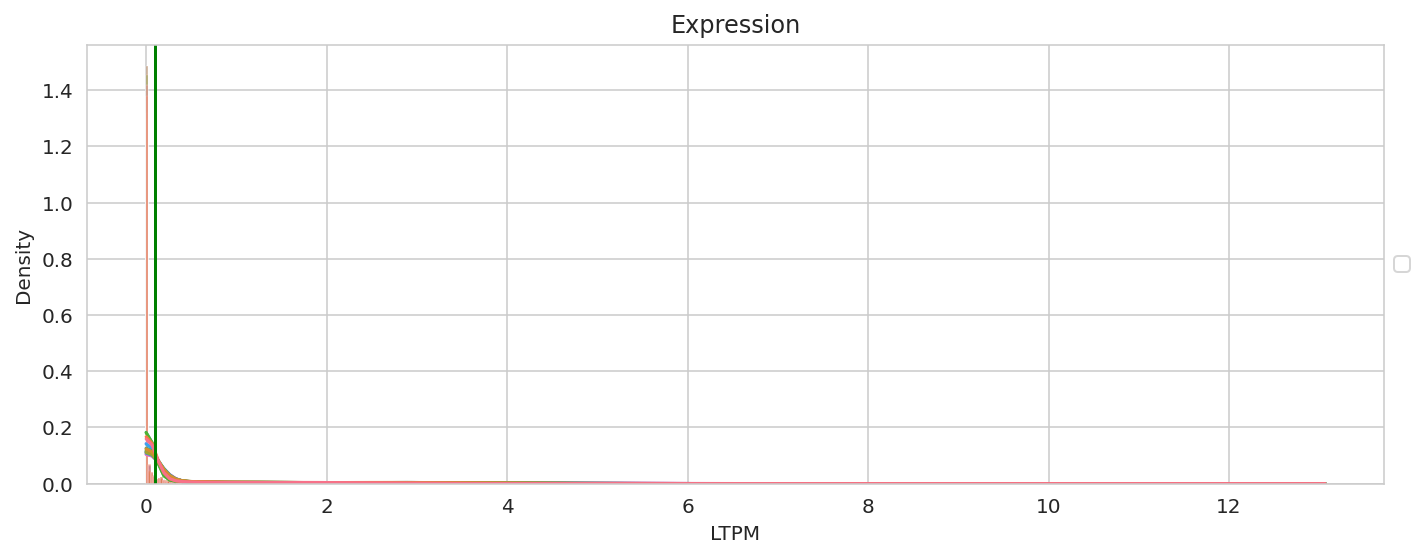

In [19]:
encode_expression, encode_tss_expression = prepare_expressed(GSE26320_EXPRESSION_TSV)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell  /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv
Total genes with positions 58387
Genes logTPM > 0.1 20769
Saved body expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1.bed
Merging overlapping regions 20769
Reduced to 18107
Saved TSS expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1_tss500.bed
TCell  /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv
Total genes with positions 58387
Genes logTPM > 0.1 21110
Saved body expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1.bed
Merging overlapping regions 21110
Reduced to 18413
Saved TSS expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1_tss500.bed
Monocyte  /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv
Total gen

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


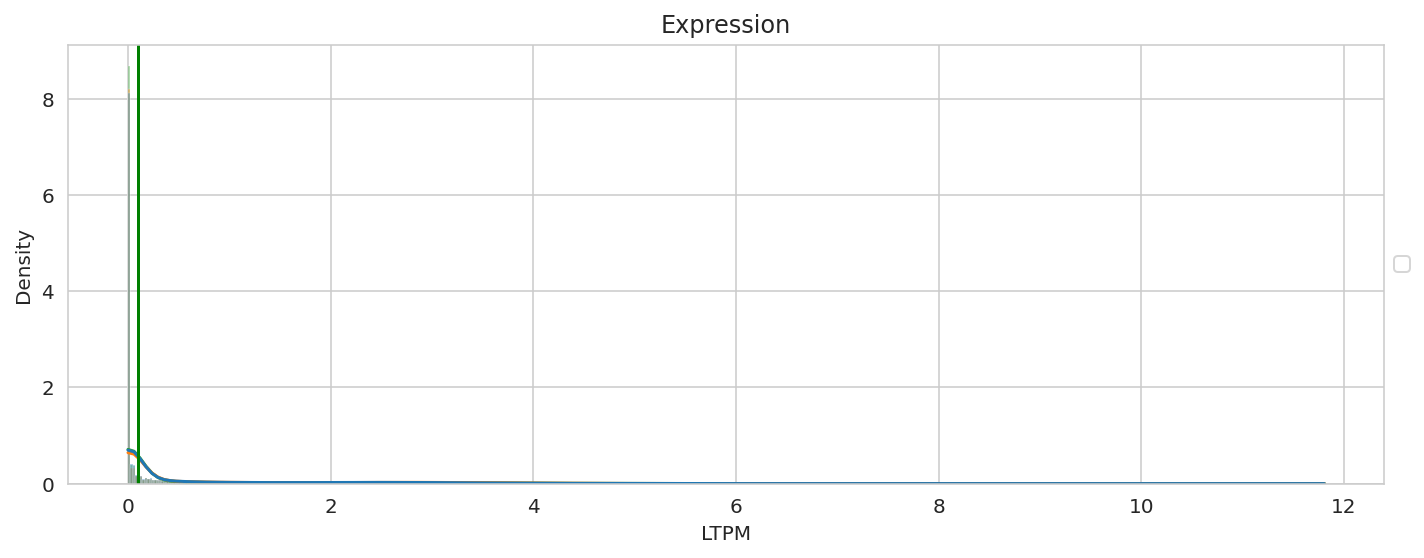

In [20]:
immune_expression, immune_tss_expression = prepare_expressed(IMMUNE_EXPRESSION_TSV)

# Hg38 Recovered promoter fraction / Correct peak fraction

In [21]:
import tempfile

def promote_fraction(df_peaks, expression_tss):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    rows = []
    for _, (c, r, tool, file) in tqdm(df_peaks[df_peaks['modification'] == 'H3K4me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows()):
        print(c, r, tool, file)
        if (c, r) not in expression_tss:
            continue
        tss_file = sorted_file(expression_tss[c, r])
        tss = lines(tss_file)
        peaks_file = sorted_file(file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            tf = sorted_file(tf)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {tss_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {tss_file} -wa -u > {tf2}
            tss_overlap = lines(tf2)
            rows.append((c, r, top, tss, peaks_file, peaks, peaks_overlap, tss_overlap, tool))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
        dtype=object
    )
    df['p'] = (df['pg'] + df['gp']) / 2
    df['precision'] = [d(x, y) for x, y in zip(df['pg'], df['peaks'])]
    df['sensitivity'] = [d(x, y) for x, y in zip(df['gp'], df['genes'])]
    df['f1'] = [
        2 / (d(1, s + 1e-10) + d(1, p + 1e-10))
        for s, p in zip(df['sensitivity'], df['precision'])]
    return df

In [22]:
encode_cpf_df = promote_fraction(df_encode_peaks, encode_tss_expression)
encode_cpf_df.sample(3)

0it [00:00, ?it/s]

H1 rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646346_H1_H3K4me3_rep2_q0.05_peaks.narrowPeak
GM12878 rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646326_GM12878_H3K4me3_rep1_q0.05_peaks.narrowPeak
HSMM rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646404_HSMM_H3K4me3_rep1_q0.05_peaks.narrowPeak
HMEC rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646384_HMEC_H3K4me3_rep1_q0.05_peaks.narrowPeak
NHEK rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646467_NHEK_H3K4me3_rep2_q0.05_peaks.narrowPeak
K562 rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646445_K562_H3K4me3_rep2_q0.05_peaks.narrowPeak
Huvec rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646424_Huvec_H3K4me3_rep1_q0.05_peaks.narrowPeak
K562 rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646444_K562_H3K4me3_rep1_q0.05_peaks.narrowPeak
HMEC rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646385_HMEC_H3K4me3_rep2_q0.05_peaks.narrowPeak
Huvec rep2 MACS2 /home/j

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
562,HSMM,rep1,8000.0,12943,/tmp/tmpy3kfur_l,8000,4267,4517,SICER,4392.0,0.533375,0.348992,0.421919
324,HMEC,rep1,10000.0,17476,/tmp/tmp0g82usf8,10000,8254,8562,MACS2 broad,8408.0,0.825400,0.489929,0.614884
192,HepG2,rep2,13000.0,14951,/tmp/tmp3jd1okih,13000,9463,8304,MACS2,8883.5,0.727923,0.555414,0.630074


In [23]:
immune_cpf_df = promote_fraction(df_immune_peaks, immune_tss_expression)
immune_cpf_df.sample(3)

0it [00:00, ?it/s]

CD34 rep2 MACS2 /home/jetbrains/data/2023_Immune/macs2/CD34_H3K4me3_rep2_hg38_ENCFF333HJE_q0.05_peaks.narrowPeak
TCellBB rep1 MACS2 /home/jetbrains/data/2023_Immune/macs2/TCellBB_H3K4me3_rep1_hg38_ENCFF167PUH_q0.05_peaks.narrowPeak
CD4ABT rep1 MACS2 /home/jetbrains/data/2023_Immune/macs2/CD4ABT_H3K4me3_rep1_hg38_ENCFF783BBS_q0.05_peaks.narrowPeak
Monocyte  MACS2 /home/jetbrains/data/2023_Immune/macs2/Monocyte_H3K4me3_hg38_ENCFF642LZZ_q0.05_peaks.narrowPeak
TCellBB rep2 MACS2 /home/jetbrains/data/2023_Immune/macs2/TCellBB_H3K4me3_rep2_hg38_ENCFF822TCP_q0.05_peaks.narrowPeak
PBMC  MACS2 /home/jetbrains/data/2023_Immune/macs2/PBMC_H3K4me3_hg38_ENCFF558XUB_q0.05_peaks.narrowPeak
TCell  MACS2 /home/jetbrains/data/2023_Immune/macs2/TCell_H3K4me3_hg38_ENCFF661HCG_q0.05_peaks.narrowPeak
NK  MACS2 /home/jetbrains/data/2023_Immune/macs2/NK_H3K4me3_hg38_ENCFF027CJG_q0.05_peaks.narrowPeak
BCell  MACS2 /home/jetbrains/data/2023_Immune/macs2/BCell_H3K4me3_hg38_ENCFF213VRU_q0.05_peaks.narrowPeak
CD34

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
67,BCell,,8000.0,18107,/tmp/tmp1rhq2ndx,8000,6749,6881,MACS2 broad,6815.0,0.843625,0.380019,0.523998
74,BCell,,15000.0,18107,/tmp/tmp1rhq2ndx,15000,10310,9922,MACS2 broad,10116.0,0.687333,0.547965,0.609787
91,TCell,,2000.0,18413,/tmp/tmp6m3ykh_w,2000,1409,1638,SICER,1523.5,0.704500,0.088959,0.157970


ENCODE


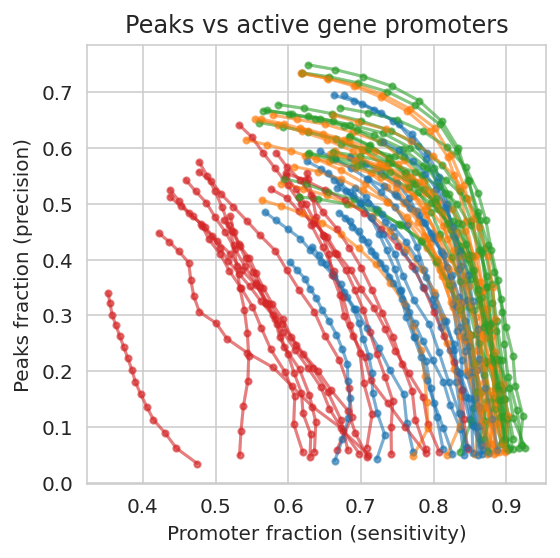

In [24]:
print('ENCODE')
plt.figure(figsize=(4, 4))
for t in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    for (c, r, t), dft in encode_cpf_df.groupby(['cell', 'replicate', 'tool']):    
        plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.2)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Promoter fraction (sensitivity)')
plt.ylabel('Peaks fraction (precision)')
plt.tight_layout()
plt.show()

Roadmap


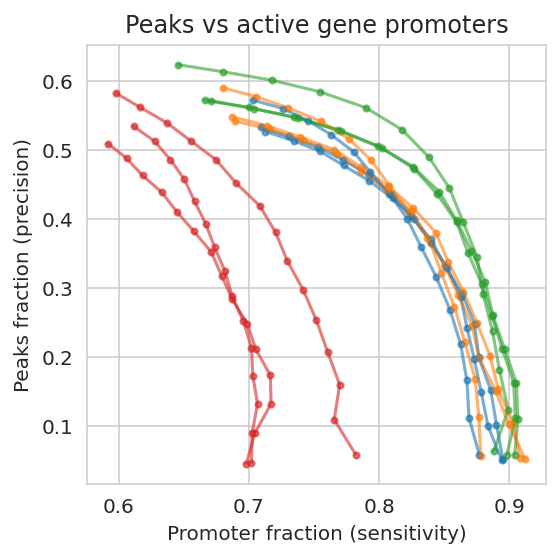

In [25]:
print('Roadmap')
plt.figure(figsize=(4, 4))
for t in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    for (c, r, t), dft in immune_cpf_df.groupby(['cell', 'replicate', 'tool']):
        plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[t], alpha=0.2)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Promoter fraction (sensitivity)')
plt.ylabel('Peaks fraction (precision)')
plt.tight_layout()
plt.show()

## Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [26]:
rows = []
for (c, r, t), dft in encode_cpf_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = 0, 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
encode_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
encode_aps_df.sample(3)

,cell,replicate,tool,auc
41,Huvec,rep2,MACS2 broad,0.360145
27,HSMM,rep1,SPAN,0.593902
37,Huvec,rep1,MACS2 broad,0.476380


ENCODE


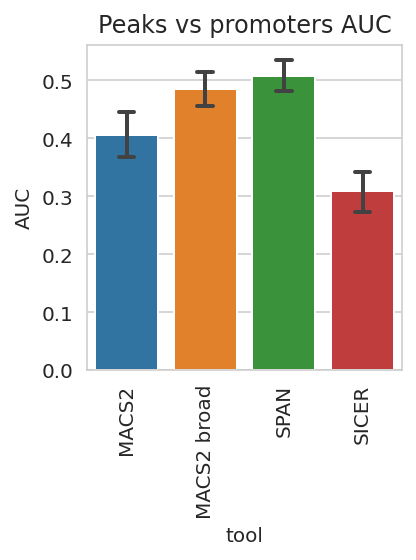

In [27]:
print('ENCODE')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
g_results = sns.barplot(data=encode_aps_df, x='tool', y='auc',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

In [28]:
rows = []
for (c, r, t), dft in immune_cpf_df.groupby(['cell', 'replicate', 'tool']):
    ap = 0
    sprev, pprev = 0, 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((c, r, t, ap))
immune_aps_df = pd.DataFrame(rows, columns=['cell', 'replicate', 'tool', 'auc'])
del rows
immune_aps_df.sample(3)

,cell,replicate,tool,auc
3,BCell,,SPAN,0.468974
10,TCell,,SICER,0.330417
5,Monocyte,,MACS2 broad,0.468208


Roadmap


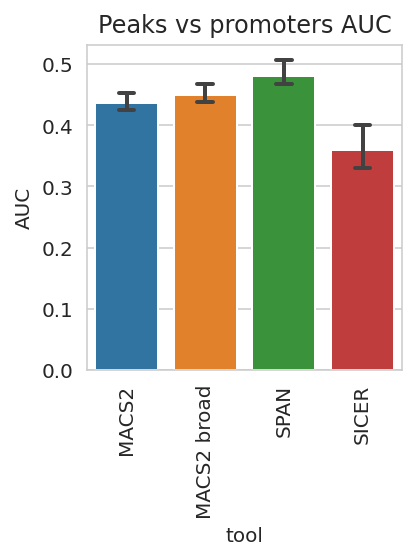

In [29]:
print('Roadmap')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
g_results = sns.barplot(data=immune_aps_df, x='tool', y='auc',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

# Jaccard H3K36me3 vs expressed genes bodies

In [30]:
import tempfile

def genes_overlap(df_peaks, expression):
    tf = tempfile.mktemp()

    rows = []
    for _, (c, r, tool, file) in tqdm(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows()):
        print(c, r, tool, file)
        if (c, r) not in expression:
            continue
        genes_file = sorted_file(expression[c, r])
        genes = lines(genes_file)
        genes_len = bedl(genes_file).sum()
        peaks_file = sorted_file(file)
        peaks = lines(peaks_file)
        peaks_len = bedl(peaks_file).sum()
        !bedtools intersect -a {peaks_file} -b {genes_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {genes_file} -wa -u > {tf}
        genes_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {genes_file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        rows.append((c, r, tool, 
                     peaks, peaks_len, genes, genes_len,
                     peaks_overlap, genes_overlap, overlap_len))

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'tool',
                 'peaks', 'peaks_len', 'genes', 'genes_len',
                 'peaks_overlap', 'genes_overlap', 'overlap_len'],
        dtype=object
    )
    df['precision'] = [d(a, b) for a, b in zip(df['peaks_overlap'], df['peaks'])]
    df['sensitivity'] = [d(a, b) for a, b in zip(df['genes_overlap'], df['genes'])]
    df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(df['sensitivity'], df['precision'])]

    df['jaccard'] = [
        d(o, p + g -o)
        for p, g, o in zip(df['peaks_len'], df['genes_len'], df['overlap_len'])
    ]
    return df

In [31]:
encode_genes_df = genes_overlap(df_encode_peaks, encode_expression)
encode_genes_df.sample(3)

0it [00:00, ?it/s]

Huvec rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646418_Huvec_H3K36me3_rep1_q0.05_peaks.narrowPeak
HMEC rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646378_HMEC_H3K36me3_rep1_q0.05_peaks.narrowPeak
HSMM rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646399_HSMM_H3K36me3_rep2_q0.05_peaks.narrowPeak
NHEK rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646461_NHEK_H3K36me3_rep2_q0.05_peaks.narrowPeak
Huvec rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646419_Huvec_H3K36me3_rep2_q0.05_peaks.narrowPeak
HMEC rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646379_HMEC_H3K36me3_rep2_q0.05_peaks.narrowPeak
NHLF rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646481_NHLF_H3K36me3_rep2_q0.05_peaks.narrowPeak
HepG2 rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646360_HepG2_H3K36me3_rep2_q0.05_peaks.narrowPeak
HSMM rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646398_HSMM_H3K36me3_rep1_q0.05_peaks.narrowPeak
H1 rep2 MACS2

,cell,replicate,tool,peaks,peaks_len,genes,genes_len,peaks_overlap,genes_overlap,overlap_len,precision,sensitivity,f1,jaccard
35,K562,rep1,SICER,34144,269764056,15270,837195303,32505,10754,267736688,0.951997,0.704257,0.809599,0.319029
58,NHEK,rep2,SPAN,22188,409427305,18674,1073301646,20666,12542,410871050,0.931404,0.671629,0.780468,0.383326
32,K562,rep1,MACS2 broad,61226,113653479,15270,837195303,58116,10297,115915460,0.949205,0.674329,0.788497,0.138832


ENCODE


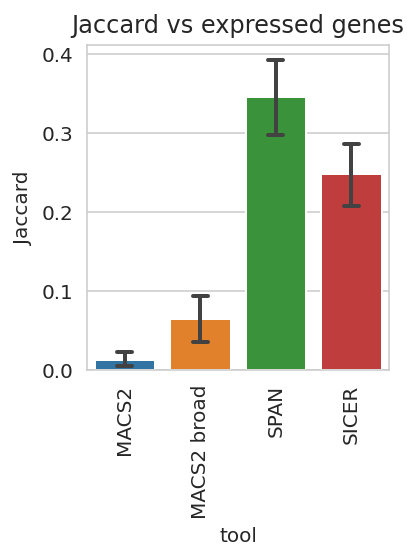

In [32]:
print('ENCODE')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=encode_genes_df, x='tool', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [33]:
immune_genes_df = genes_overlap(df_immune_peaks, immune_expression)
immune_genes_df.sample(3)

0it [00:00, ?it/s]

CD4 rep1 MACS2 /home/jetbrains/data/2023_Immune/macs2/CD4_H3K36me3_rep1_hg38_ENCFF013ZAX_q0.05_peaks.narrowPeak
CD34  MACS2 /home/jetbrains/data/2023_Immune/macs2/CD34_H3K36me3_hg38_ENCFF924KBL_q0.05_peaks.narrowPeak
Monocyte  MACS2 /home/jetbrains/data/2023_Immune/macs2/Monocyte_H3K36me3_hg38_ENCFF164MUD_q0.05_peaks.narrowPeak
CD4  MACS2 /home/jetbrains/data/2023_Immune/macs2/CD4_H3K36me3_hg38_ENCFF489CFC_q0.05_peaks.narrowPeak
CD34 rep1 MACS2 /home/jetbrains/data/2023_Immune/macs2/CD34_H3K36me3_rep1_hg38_ENCFF785IJG_q0.05_peaks.narrowPeak
TCell  MACS2 /home/jetbrains/data/2023_Immune/macs2/TCell_H3K36me3_hg38_ENCFF783YIM_q0.05_peaks.narrowPeak
PBMC  MACS2 /home/jetbrains/data/2023_Immune/macs2/PBMC_H3K36me3_hg38_ENCFF584TDL_q0.05_peaks.narrowPeak
BCell  MACS2 /home/jetbrains/data/2023_Immune/macs2/BCell_H3K36me3_hg38_ENCFF207YSM_q0.05_peaks.narrowPeak
Monocyte  MACS2 broad /home/jetbrains/data/2023_Immune/macs2/Monocyte_H3K36me3_hg38_ENCFF164MUD_broad0.1_peaks.broadPeak
CD4 rep1 MACS

,cell,replicate,tool,peaks,peaks_len,genes,genes_len,peaks_overlap,genes_overlap,overlap_len,precision,sensitivity,f1,jaccard
10,BCell,,SPAN,29659,411700729,20769,1118480271,28370,14142,424106651,0.956539,0.680919,0.795532,0.383434
9,Monocyte,,SPAN,30297,375861818,18584,971224167,29326,13424,386922164,0.967951,0.722342,0.827302,0.402975
3,Monocyte,,MACS2 broad,105833,199110989,18584,971224167,102429,12042,207797755,0.967836,0.647977,0.776247,0.215885


Roadmap


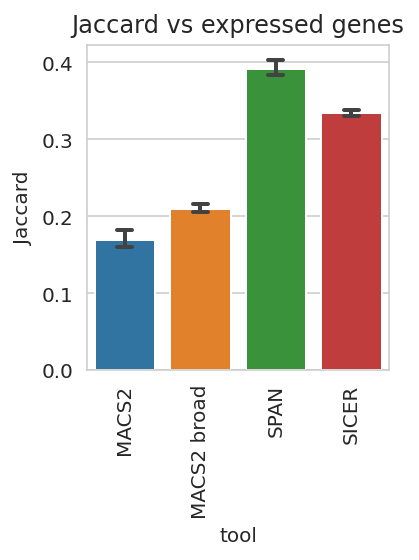

In [34]:
print('Roadmap')
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
sns.barplot(data=immune_genes_df, x='tool', y='jaccard',
            ax=ax,
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
            )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

## Compare ratio of peaks to genes

In [35]:
import tempfile

def genes_peaks_ratio(df_peaks, expression):
    tf = tempfile.mktemp()

    rows = []
    for _, (c, r, tool, file) in tqdm(df_peaks[df_peaks['modification'] == 'H3K36me3']
                                      [['cell', 'replicate', 'tool', 'file']].iterrows()):
        print(c, r, tool, file)
        if (c, r) not in expression:
            continue
        genes_file = sorted_file(expression[c, r])
        peaks_file = sorted_file(file)
        ! echo "" > {tf}
        ! bedtools intersect -a {genes_file} -b {peaks_file} -wa -wb > {tf}
        expr_cols = len(pd.read_csv(genes_file, sep='\t', header=None, nrows=1).columns)
        try:
            tf_expression = pd.read_csv(tf, sep='\t', header=None)
            genes = len(tf_expression.groupby([0, 1, 2]).count())
            peaks = len(tf_expression.groupby([expr_cols, expr_cols + 1, expr_cols + 2]).count())
            rows.append((c, r, tool, genes, peaks))
        except:
            pass

    df = pd.DataFrame(
        rows,
        columns=['cell', 'replicate', 'tool', 'genes', 'peaks'],
        dtype=object
    )
    df['peaks_to_genes'] = df['peaks'] / df['genes']
    return df

In [36]:
encode_genes_ratios = genes_peaks_ratio(df_encode_peaks, encode_expression)
encode_genes_ratios.sample(3)

0it [00:00, ?it/s]

Huvec rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646418_Huvec_H3K36me3_rep1_q0.05_peaks.narrowPeak
HMEC rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646378_HMEC_H3K36me3_rep1_q0.05_peaks.narrowPeak
HSMM rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646399_HSMM_H3K36me3_rep2_q0.05_peaks.narrowPeak
NHEK rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646461_NHEK_H3K36me3_rep2_q0.05_peaks.narrowPeak
Huvec rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646419_Huvec_H3K36me3_rep2_q0.05_peaks.narrowPeak
HMEC rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646379_HMEC_H3K36me3_rep2_q0.05_peaks.narrowPeak
NHLF rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646481_NHLF_H3K36me3_rep2_q0.05_peaks.narrowPeak
HepG2 rep2 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646360_HepG2_H3K36me3_rep2_q0.05_peaks.narrowPeak
HSMM rep1 MACS2 /home/jetbrains/data/2023_GSE26320/macs2/GSM646398_HSMM_H3K36me3_rep1_q0.05_peaks.narrowPeak
H1 rep2 MACS2

,cell,replicate,tool,genes,peaks,peaks_to_genes
17,Huvec,rep1,MACS2 broad,10764,37815,3.513099
16,NHLF,rep2,MACS2 broad,12332,55757,4.521327
25,K562,rep2,MACS2 broad,6131,20444,3.334529


ENCODE


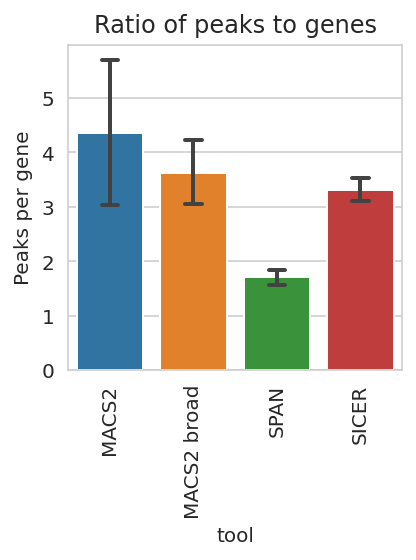

In [37]:
print('ENCODE')
plt.figure(figsize=(3, 4))
ax = plt.axes()
sns.barplot(data=encode_genes_ratios, y='peaks_to_genes', x='tool', ax=ax,
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
            )
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

In [38]:
immune_genes_ratios = genes_peaks_ratio(df_immune_peaks, immune_expression)
immune_genes_ratios.sample(3)

0it [00:00, ?it/s]

CD4 rep1 MACS2 /home/jetbrains/data/2023_Immune/macs2/CD4_H3K36me3_rep1_hg38_ENCFF013ZAX_q0.05_peaks.narrowPeak
CD34  MACS2 /home/jetbrains/data/2023_Immune/macs2/CD34_H3K36me3_hg38_ENCFF924KBL_q0.05_peaks.narrowPeak
Monocyte  MACS2 /home/jetbrains/data/2023_Immune/macs2/Monocyte_H3K36me3_hg38_ENCFF164MUD_q0.05_peaks.narrowPeak
CD4  MACS2 /home/jetbrains/data/2023_Immune/macs2/CD4_H3K36me3_hg38_ENCFF489CFC_q0.05_peaks.narrowPeak
CD34 rep1 MACS2 /home/jetbrains/data/2023_Immune/macs2/CD34_H3K36me3_rep1_hg38_ENCFF785IJG_q0.05_peaks.narrowPeak
TCell  MACS2 /home/jetbrains/data/2023_Immune/macs2/TCell_H3K36me3_hg38_ENCFF783YIM_q0.05_peaks.narrowPeak
PBMC  MACS2 /home/jetbrains/data/2023_Immune/macs2/PBMC_H3K36me3_hg38_ENCFF584TDL_q0.05_peaks.narrowPeak
BCell  MACS2 /home/jetbrains/data/2023_Immune/macs2/BCell_H3K36me3_hg38_ENCFF207YSM_q0.05_peaks.narrowPeak
Monocyte  MACS2 broad /home/jetbrains/data/2023_Immune/macs2/Monocyte_H3K36me3_hg38_ENCFF164MUD_broad0.1_peaks.broadPeak
CD4 rep1 MACS

,cell,replicate,tool,genes,peaks,peaks_to_genes
7,TCell,,SICER,13358,31827,2.382617
1,TCell,,MACS2,12673,178040,14.048765
10,BCell,,SPAN,14141,28370,2.006223


Immune


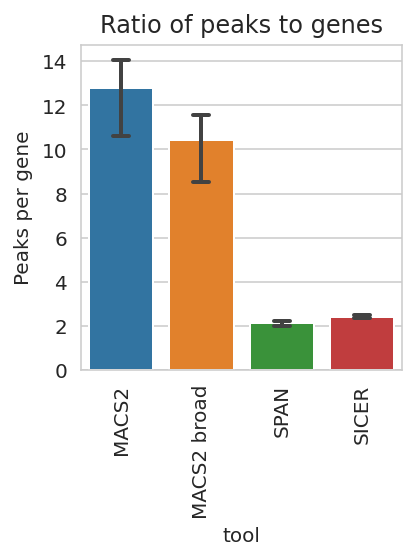

In [39]:
print('Immune')
plt.figure(figsize=(3, 4))
ax = plt.axes()
sns.barplot(data=immune_genes_ratios, y='peaks_to_genes', x='tool', ax=ax,
            capsize=.2, errwidth=2,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
            )
ax.set_ylabel('Peaks per gene')
ax.title.set_text('Ratio of peaks to genes')
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()